# Flower federated learning project

In this notebook, we will deploy the Flower framework and train a VGG16 model over the CIFAR10 dataset using the FedAVG algorithm for 50 rounds with 5 clients. We will choose clients 0-4 and use 3 epochs per round. Then we will train the model in a centralized fashion using the combined data from all 5 clients for 50 epochs. Finally, we will plot the computed metrics (Kappa value, F1 measure, Accuracy, ROC value) for both the centralized and federated approaches in separate plots and compare the results.

## Part 1: Setup

Let's make sure that we have everything we need.

### 1.1. Installing dependencies

First, we install the necessary packages:

In [1]:
!pip install -qv flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib

  Using cached torch-2.3.0-cp311-cp311-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached torchvision-0.18.0-cp311-cp311-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached flwr-1.8.0-py3-none-any.whl.metadata (15 kB)
  Using cached flwr_datasets-0.1.0-py3-none-any.whl.metadata (5.5 kB)
  Using cached iterators-0.0.2-py3-none-any.whl.metadata (2.5 kB)
  Using cached pycryptodome-3.20.0-cp35-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached pydantic-1.10.15-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (150 kB)
  Using cached ray-2.6.3-cp311-cp311-manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached typer-0.9.4-py3-none-any.whl.metadata (14 kB)
  Using cached filelock-3.14.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached frozenlist-1.4.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  

Then, let's pull our imports. We'll be using **numpy** for managing weight arrays, **torch** to build our neural networks and **torchvision** for downloading and setting our datasets.

In [2]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models import vgg16
from torch.utils.data import DataLoader

from flwr_datasets import FederatedDataset
from flwr.common import Metrics

import flwr as fl

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.3.0+cu121 and Flower 1.8.0


### 1.2. Data loading

Let's use the CIFAR10 dataset.

In [3]:
# Global variables
NUM_CLIENTS = 5
NUM_ROUNDS = 50
FEDERATED_EPOCHS_PER_ROUND = 3
CENTRALIZED_EPOCHS_TOTAL = 50
BATCH_SIZE = 32
DATASET = "cifar10"

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [4]:
def load_datasets(partitioner=None):
    if partitioner is None:
        fds = FederatedDataset(dataset=DATASET, partitioners={"train": NUM_CLIENTS})
    else:
        fds = FederatedDataset(dataset=DATASET, partitioners={"train": partitioner})

    def apply_transforms(batch):
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        batch["img"] = [transform(img) for img in batch["img"]]
        return batch

    trainloaders = []
    valloaders = []
    for partition_id in range(NUM_CLIENTS):
        partition = fds.load_partition(partition_id, "train")
        partition = partition.with_transform(apply_transforms)
        partition = partition.train_test_split(train_size=0.8, seed=42)
        trainloaders.append(DataLoader(partition["train"], batch_size=BATCH_SIZE))
        valloaders.append(DataLoader(partition["test"], batch_size=BATCH_SIZE))
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

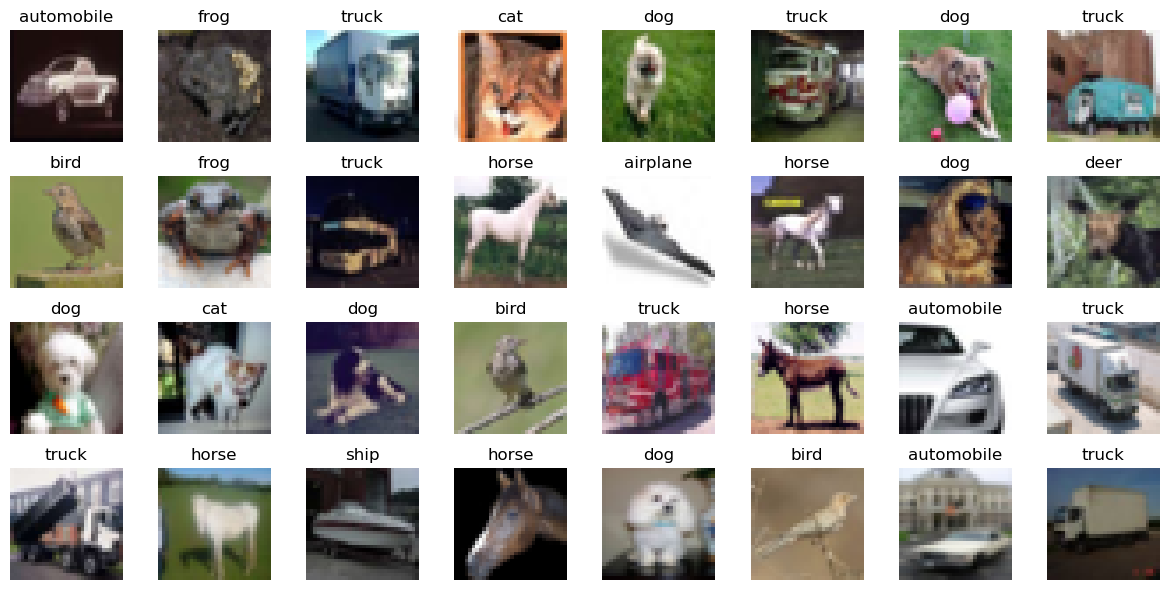

In [5]:
batch = next(iter(trainloaders[0]))
images, labels = batch["img"], batch["label"]
# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloaders[0].dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

### 1.3. Model Definition 

Let's continue with the usual model definition (including `set_parameters` and `get_parameters`), training and test functions:

In [6]:
# Torch equivalent of the given model definition
class Net(nn.Module):
    def __init__(self, classes=10, input_shape=(32, 32, 3), dimension='VGG16'):
        super(Net, self).__init__()
        self.features = self._make_layers(cfg[dimension], input_shape)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, classes),
            nn.Softmax(dim=1)
        )
    
    def _make_layers(self, cfg, input_shape):
        layers = []
        in_channels = input_shape[2]
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

class NeuralNetworkManager:
    @staticmethod
    def get_parameters(net) -> List[np.ndarray]:
        params = [val.cpu().numpy() for _, val in net.state_dict().items()]
        return params

    @staticmethod
    def set_parameters(net, parameters: List[np.ndarray]):
        params_dict = zip(net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k:torch.Tensor(v) for k, v in params_dict if len(v.shape) > 0})
        net.load_state_dict(state_dict, strict=False)
        return net

    @staticmethod
    def train(net, trainloader, epochs: int, verbose=False):
        """Train the network on the training set."""
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(net.parameters())
        net.train()
        for epoch in range(epochs):
            correct, total, epoch_loss = 0, 0, 0.0
            for batch in trainloader:
                images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                # Metrics
                epoch_loss += loss
                total += labels.size(0)
                correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
            epoch_loss /= len(trainloader.dataset)
            epoch_acc = correct / total
            if verbose:
                print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

    @staticmethod
    def test(net, testloader):
        """Evaluate the network on the entire test set."""
        criterion = torch.nn.CrossEntropyLoss()
        correct, total, loss = 0, 0, 0.0
        net.eval()
        with torch.no_grad():
            for batch in testloader:
                images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
                outputs = net(images)
                loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        loss /= len(testloader.dataset)
        accuracy = correct / total
        return loss, accuracy

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

### 1.4. Federating with a Flower client

To implement the Flower client, we (again) create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`. Here, we also pass the `cid` to the client and use it log additional details:

In [7]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader, manager=NeuralNetworkManager):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.manager=manager

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return self.manager.get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")
        self.manager.set_parameters(self.net, parameters)
        self.manager.train(self.net, self.trainloader, epochs=local_epochs)
        return self.manager.get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        self.manager.set_parameters(self.net, parameters)
        loss, accuracy = self.manager.test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [8]:
def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

###  1.5 Define configuration
Define arbitrary configuration functions

In [9]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "local_epochs": FEDERATED_EPOCHS_PER_ROUND,
    }
    return config

Pass the function to the FedAvg strategy before starting the simulation:

In [ ]:
# Create an instance of the model and get the parameters
params = NeuralNetworkManager.get_parameters(Net())

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.1,
    fraction_evaluate=0.1,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average,
    on_fit_config_fn=fit_config,
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
2024-06-02 12:41:17,738	WARNING services.py:1832 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67104768 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=9.85gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-06-02 12:41:17,794	INFO worker.py:1621 -- Started a local Ray instance.
